<a href="https://colab.research.google.com/github/vidyashankarappa/DeepLearning/blob/main/DeepLearningPneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [ ]:
# Install the torchmetrics package for storing loss, evaluation metrics, etc.
!pip install lightning-utilities
!pip install torchmetrics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 53.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image
from torchmetrics import MeanMetric, Accuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score

In [ ]:
# Make sure to change runtime to GPU
# Check if GPU is avaiable
device = "cuda" if torch.cuda.is_available() \
          else "mps" if torch.mps.is_available() \
          else "cpu"
print("Device:", device)

Device: cuda


#Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile
import os

#zip_path = '/content/drive/MyDrive/PneumoniaDataset/archive.zip'

zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/pneumonia_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted!")


Dataset extracted!


In [ ]:
# unzip a zip file
!unzip "/content/drive/My Drive/archive.zip" -d raf-db-dataset

Streaming output truncated to the last 5000 lines.
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: raf-db-dataset/chest_xray/train/NORMAL/IM-0444-

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


#Augumentation

In [ ]:
train_transform = v2.Compose([
    v2.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

eval_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_data = ImageFolder("/content/pneumonia_dataset/chest_xray/train", transform=train_transform)
val_data = ImageFolder("/content/pneumonia_dataset/chest_xray/val", transform=eval_transform)
test_data = ImageFolder("/content/pneumonia_dataset/chest_xray/test", transform=eval_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

classes = train_data.classes
num_class = len(classes)

In [ ]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size

train_indices, val_indices = random_split(range(len(train_data)), [train_size, val_size])
train_set = torch.utils.data.Subset(train_data, train_indices)
val_set = torch.utils.data.Subset(val_data, val_indices)

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)


#model

In [ ]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(weights='IMAGENET1K_V1')


model.fc = nn.Linear(model.fc.in_features, num_class)

# Move the model to the appropriate device (GPU/CPU)
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


#Experiment

In [ ]:
from torchmetrics import MeanMetric

def train_one_epoch(model, dataloader):
    losses = MeanMetric().to(device)
    acc = Accuracy(task='multiclass', num_classes=num_class).to(device)
    model.train()

    for X, Y in tqdm(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()

        preds = preds.argmax(dim=1)
        losses.update(loss, X.size(0))
        acc.update(preds, Y)

    return losses.compute().item(), acc.compute().item()

def validation_one_epoch(model, dataloader):
    losses = MeanMetric().to(device)
    acc = Accuracy(task='multiclass', num_classes=num_class).to(device)
    model.eval()

    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            loss = criterion(preds, Y)
            preds = preds.argmax(dim=1)

            losses.update(loss, X.size(0))
            acc.update(preds, Y)

    return losses.compute().item(), acc.compute().item()


In [ ]:
import pandas as pd

history = pd.DataFrame()
epochs = 25 #

for i in range(epochs):

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validation_one_epoch(model, val_loader)

    stats = pd.DataFrame({
        "epoch": [i],
        "train_loss": [train_loss],
        "train_acc": [train_acc],
        "val_loss": [val_loss],
        "val_acc": [val_acc]
    })
    history = pd.concat([history, stats], ignore_index=True)
    print(stats.to_dict(orient="records")[0])

100%|██████████| 163/163 [05:21<00:00,  1.97s/it]


{'epoch': 0, 'train_loss': 0.21931342780590057, 'train_acc': 0.9164110422134399, 'val_loss': 0.40210142731666565, 'val_acc': 0.75}


100%|██████████| 163/163 [05:19<00:00,  1.96s/it]


{'epoch': 1, 'train_loss': 0.1916504055261612, 'train_acc': 0.9258052110671997, 'val_loss': 0.35364362597465515, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:21<00:00,  1.97s/it]


{'epoch': 2, 'train_loss': 0.184839129447937, 'train_acc': 0.9281058311462402, 'val_loss': 0.34452876448631287, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:19<00:00,  1.96s/it]


{'epoch': 3, 'train_loss': 0.15573672950267792, 'train_acc': 0.9413343667984009, 'val_loss': 0.29194459319114685, 'val_acc': 0.875}


100%|██████████| 163/163 [05:20<00:00,  1.97s/it]


{'epoch': 4, 'train_loss': 0.158912792801857, 'train_acc': 0.9376916885375977, 'val_loss': 0.3373696208000183, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:20<00:00,  1.97s/it]


{'epoch': 5, 'train_loss': 0.14994730055332184, 'train_acc': 0.9422929286956787, 'val_loss': 0.42418938875198364, 'val_acc': 0.6875}


100%|██████████| 163/163 [05:21<00:00,  1.97s/it]


{'epoch': 6, 'train_loss': 0.13846278190612793, 'train_acc': 0.9490030407905579, 'val_loss': 0.3336769938468933, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:22<00:00,  1.98s/it]


{'epoch': 7, 'train_loss': 0.1316448450088501, 'train_acc': 0.9507285356521606, 'val_loss': 0.42549532651901245, 'val_acc': 0.6875}


100%|██████████| 163/163 [05:23<00:00,  1.99s/it]


{'epoch': 8, 'train_loss': 0.1359482705593109, 'train_acc': 0.9468941688537598, 'val_loss': 0.2626909613609314, 'val_acc': 0.875}


100%|██████████| 163/163 [05:22<00:00,  1.98s/it]


{'epoch': 9, 'train_loss': 0.12388204783201218, 'train_acc': 0.9555214643478394, 'val_loss': 0.3719044029712677, 'val_acc': 0.75}


100%|██████████| 163/163 [05:19<00:00,  1.96s/it]


{'epoch': 10, 'train_loss': 0.12141148000955582, 'train_acc': 0.9524539709091187, 'val_loss': 0.29192057251930237, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:21<00:00,  1.97s/it]


{'epoch': 11, 'train_loss': 0.12180318683385849, 'train_acc': 0.9528374075889587, 'val_loss': 0.25834566354751587, 'val_acc': 0.875}


100%|██████████| 163/163 [05:20<00:00,  1.97s/it]


{'epoch': 12, 'train_loss': 0.1122358962893486, 'train_acc': 0.9555214643478394, 'val_loss': 0.28842106461524963, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:20<00:00,  1.97s/it]


{'epoch': 13, 'train_loss': 0.11379873007535934, 'train_acc': 0.9583972096443176, 'val_loss': 0.3691807985305786, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:18<00:00,  1.95s/it]


{'epoch': 14, 'train_loss': 0.10933446884155273, 'train_acc': 0.9566717743873596, 'val_loss': 0.34363797307014465, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:21<00:00,  1.97s/it]


{'epoch': 15, 'train_loss': 0.1077049970626831, 'train_acc': 0.9620398879051208, 'val_loss': 0.2469751238822937, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:17<00:00,  1.95s/it]


{'epoch': 16, 'train_loss': 0.101845383644104, 'train_acc': 0.9610812664031982, 'val_loss': 0.34767183661460876, 'val_acc': 0.75}


100%|██████████| 163/163 [05:18<00:00,  1.95s/it]


{'epoch': 17, 'train_loss': 0.1098569855093956, 'train_acc': 0.9583972096443176, 'val_loss': 0.33518245816230774, 'val_acc': 0.75}


100%|██████████| 163/163 [05:16<00:00,  1.94s/it]


{'epoch': 18, 'train_loss': 0.10472427308559418, 'train_acc': 0.9620398879051208, 'val_loss': 0.2896403968334198, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:13<00:00,  1.92s/it]


{'epoch': 19, 'train_loss': 0.10667041689157486, 'train_acc': 0.9624233245849609, 'val_loss': 0.2201327681541443, 'val_acc': 0.875}


100%|██████████| 163/163 [05:16<00:00,  1.94s/it]


{'epoch': 20, 'train_loss': 0.09431762993335724, 'train_acc': 0.9674080014228821, 'val_loss': 0.3128869831562042, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:12<00:00,  1.92s/it]


{'epoch': 21, 'train_loss': 0.09708062559366226, 'train_acc': 0.9629984498023987, 'val_loss': 0.25348126888275146, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:13<00:00,  1.92s/it]


{'epoch': 22, 'train_loss': 0.0975976288318634, 'train_acc': 0.9643405079841614, 'val_loss': 0.3082532584667206, 'val_acc': 0.8125}


100%|██████████| 163/163 [05:14<00:00,  1.93s/it]


{'epoch': 23, 'train_loss': 0.09772238880395889, 'train_acc': 0.9637653231620789, 'val_loss': 0.33490055799484253, 'val_acc': 0.75}


100%|██████████| 163/163 [05:15<00:00,  1.94s/it]


{'epoch': 24, 'train_loss': 0.10170750319957733, 'train_acc': 0.9635736346244812, 'val_loss': 0.2683563828468323, 'val_acc': 0.8125}


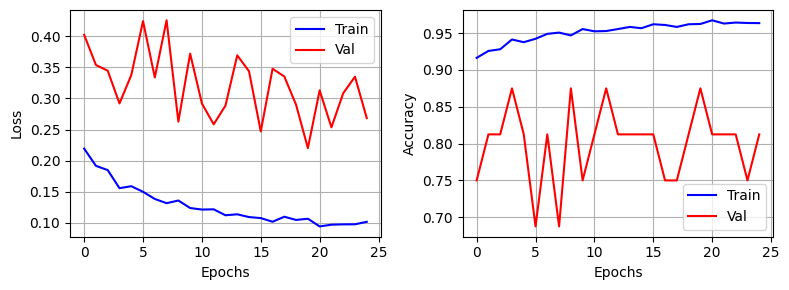

In [ ]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Val", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Val", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8, 3))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Val", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, max(max(history["train_loss"]), max(history["val_loss"])) * 1.1)  # Start from 0
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Val", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)  # Accuracy always ranges from 0 to 1
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
test_acc = Accuracy(task='multiclass', num_classes=num_class).to(device)
conf_mat = ConfusionMatrix(task='multiclass', num_classes=num_class).to(device)
precision = Precision(task='multiclass', num_classes=num_class, average='macro').to(device)
recall = Recall(task='multiclass', num_classes=num_class, average='macro').to(device)
f1 = F1Score(task='multiclass', num_classes=num_class, average='macro').to(device)

model.eval()
with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        preds = model(X).argmax(dim=1)

        test_acc.update(preds, Y)
        conf_mat.update(preds, Y)
        precision.update(preds, Y)
        recall.update(preds, Y)
        f1.update(preds, Y)

print("Confusion Matrix:\n", conf_mat.compute())
print("Accuracy:", test_acc.compute().item())
print("Precision:", precision.compute().item())
print("Recall:", recall.compute().item())
print("F1 Score:", f1.compute().item())


Confusion Matrix:
 tensor([[205,  29],
        [  4, 386]], device='cuda:0')
Accuracy: 0.9471153616905212
Precision: 0.9554908275604248
Recall: 0.9329059720039368
F1 Score: 0.9422570466995239


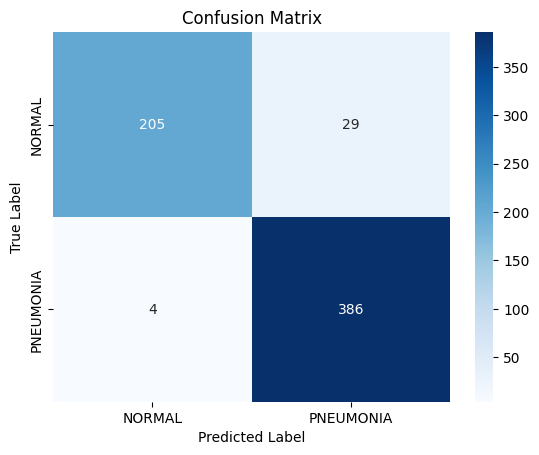

In [ ]:
# Visualize confusion matrix
sns.heatmap(conf_mat.compute().cpu(), annot=True, fmt="d",
            cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


#VGG16

In [ ]:
import torchvision.models as models
import torch.nn as nn


model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

num_classes = 2
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s]


In [ ]:
import torch

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from torchmetrics import MeanMetric

def train_one_epoch(model, dataloader):
    losses = MeanMetric().to(device)
    acc = Accuracy(task='multiclass', num_classes=num_class).to(device)
    model.train()

    for X, Y in tqdm(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()

        preds = preds.argmax(dim=1)
        losses.update(loss, X.size(0))
        acc.update(preds, Y)

    return losses.compute().item(), acc.compute().item()

def validation_one_epoch(model, dataloader):
    losses = MeanMetric().to(device)
    acc = Accuracy(task='multiclass', num_classes=num_class).to(device)
    model.eval()

    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            loss = criterion(preds, Y)
            preds = preds.argmax(dim=1)

            losses.update(loss, X.size(0))
            acc.update(preds, Y)

    return losses.compute().item(), acc.compute().item()


In [ ]:
import pandas as pd

history = pd.DataFrame()
epochs = 10

for i in range(epochs):

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validation_one_epoch(model, val_loader)

    stats = pd.DataFrame({
        "epoch": [i],
        "train_loss": [train_loss],
        "train_acc": [train_acc],
        "val_loss": [val_loss],
        "val_acc": [val_acc]
    })
    history = pd.concat([history, stats], ignore_index=True)
    print(stats.to_dict(orient="records")[0])

100%|██████████| 163/163 [05:30<00:00,  2.03s/it]


{'epoch': 0, 'train_loss': 0.26677465438842773, 'train_acc': 0.8853527903556824, 'val_loss': 0.18211212754249573, 'val_acc': 1.0}


100%|██████████| 163/163 [05:30<00:00,  2.03s/it]


{'epoch': 1, 'train_loss': 0.14982129633426666, 'train_acc': 0.9444018602371216, 'val_loss': 0.44526207447052, 'val_acc': 0.75}


100%|██████████| 163/163 [05:32<00:00,  2.04s/it]


{'epoch': 2, 'train_loss': 0.1190825030207634, 'train_acc': 0.9541794657707214, 'val_loss': 0.1105739027261734, 'val_acc': 0.9375}


100%|██████████| 163/163 [05:32<00:00,  2.04s/it]


{'epoch': 3, 'train_loss': 0.11258576065301895, 'train_acc': 0.9566717743873596, 'val_loss': 0.2386564016342163, 'val_acc': 0.875}


100%|██████████| 163/163 [05:32<00:00,  2.04s/it]


{'epoch': 4, 'train_loss': 0.11364202946424484, 'train_acc': 0.9572469592094421, 'val_loss': 0.061895254999399185, 'val_acc': 1.0}


100%|██████████| 163/163 [05:32<00:00,  2.04s/it]


{'epoch': 5, 'train_loss': 0.08902785181999207, 'train_acc': 0.9679831266403198, 'val_loss': 0.06778797507286072, 'val_acc': 1.0}


100%|██████████| 163/163 [05:32<00:00,  2.04s/it]


{'epoch': 6, 'train_loss': 0.10266135632991791, 'train_acc': 0.9622315764427185, 'val_loss': 0.10056689381599426, 'val_acc': 0.9375}


100%|██████████| 163/163 [05:37<00:00,  2.07s/it]


{'epoch': 7, 'train_loss': 0.08038236945867538, 'train_acc': 0.9712423086166382, 'val_loss': 0.1327161192893982, 'val_acc': 0.9375}


100%|██████████| 163/163 [05:36<00:00,  2.07s/it]


{'epoch': 8, 'train_loss': 0.08258509635925293, 'train_acc': 0.967024564743042, 'val_loss': 0.16096848249435425, 'val_acc': 0.875}


100%|██████████| 163/163 [05:36<00:00,  2.07s/it]


{'epoch': 9, 'train_loss': 0.08625715225934982, 'train_acc': 0.9672162532806396, 'val_loss': 0.32638415694236755, 'val_acc': 0.8125}


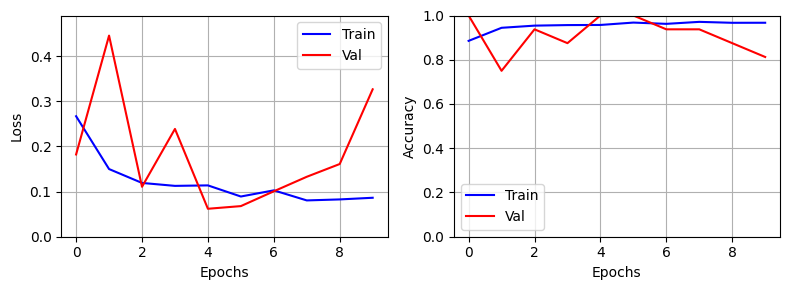

In [ ]:
plt.figure(figsize=(8, 3))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Val", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, max(max(history["train_loss"]), max(history["val_loss"])) * 1.1)  # Start from 0
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Val", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
test_acc = Accuracy(task='multiclass', num_classes=num_class).to(device)
conf_mat = ConfusionMatrix(task='multiclass', num_classes=num_class).to(device)
precision = Precision(task='multiclass', num_classes=num_class, average='macro').to(device)
recall = Recall(task='multiclass', num_classes=num_class, average='macro').to(device)
f1 = F1Score(task='multiclass', num_classes=num_class, average='macro').to(device)

model.eval()
with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        preds = model(X).argmax(dim=1)

        test_acc.update(preds, Y)
        conf_mat.update(preds, Y)
        precision.update(preds, Y)
        recall.update(preds, Y)
        f1.update(preds, Y)

print("Confusion Matrix:\n", conf_mat.compute())
print("Accuracy:", test_acc.compute().item())
print("Precision:", precision.compute().item())
print("Recall:", recall.compute().item())
print("F1 Score:", f1.compute().item())


Confusion Matrix:
 tensor([[179,  55],
        [  1, 389]], device='cuda:0')
Accuracy: 0.9102563858032227
Precision: 0.9352852702140808
Recall: 0.8811965584754944
F1 Score: 0.8987939953804016


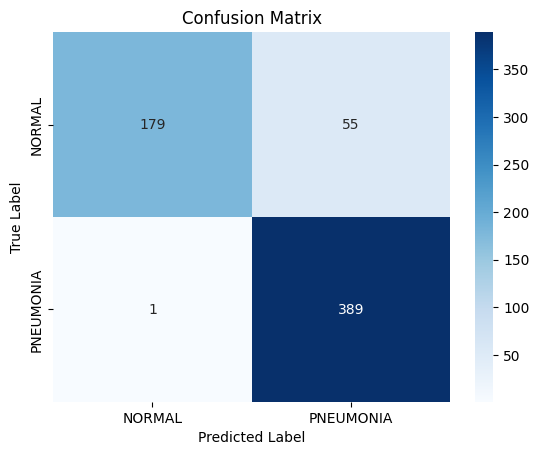

In [ ]:
# Visualize confusion matrix
sns.heatmap(conf_mat.compute().cpu(), annot=True, fmt="d",
            cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


#Custom

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN2(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
model = CustomCNN2(num_classes=2).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validation_one_epoch(model, val_loader)

    # Print stats
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

100%|██████████| 163/163 [05:01<00:00,  1.85s/it]


Epoch 0: Train Loss = 0.4018, Train Acc = 0.8129, Val Loss = 1.6115, Val Acc = 0.5000


100%|██████████| 163/163 [04:58<00:00,  1.83s/it]


Epoch 1: Train Loss = 0.3205, Train Acc = 0.8637, Val Loss = 1.0643, Val Acc = 0.5000


100%|██████████| 163/163 [04:58<00:00,  1.83s/it]


Epoch 2: Train Loss = 0.2952, Train Acc = 0.8773, Val Loss = 0.6679, Val Acc = 0.7500


100%|██████████| 163/163 [04:58<00:00,  1.83s/it]


Epoch 3: Train Loss = 0.2784, Train Acc = 0.8861, Val Loss = 0.5743, Val Acc = 0.6250


100%|██████████| 163/163 [04:58<00:00,  1.83s/it]


Epoch 4: Train Loss = 0.2674, Train Acc = 0.8867, Val Loss = 0.7687, Val Acc = 0.6250


100%|██████████| 163/163 [04:58<00:00,  1.83s/it]


Epoch 5: Train Loss = 0.2507, Train Acc = 0.8947, Val Loss = 0.9447, Val Acc = 0.5625


100%|██████████| 163/163 [04:58<00:00,  1.83s/it]


Epoch 6: Train Loss = 0.2251, Train Acc = 0.9055, Val Loss = 0.7825, Val Acc = 0.5625


100%|██████████| 163/163 [04:58<00:00,  1.83s/it]


Epoch 7: Train Loss = 0.2166, Train Acc = 0.9156, Val Loss = 0.7515, Val Acc = 0.5625


100%|██████████| 163/163 [04:59<00:00,  1.84s/it]


Epoch 8: Train Loss = 0.2048, Train Acc = 0.9199, Val Loss = 1.0018, Val Acc = 0.5625


100%|██████████| 163/163 [04:55<00:00,  1.81s/it]


Epoch 9: Train Loss = 0.2108, Train Acc = 0.9170, Val Loss = 0.6617, Val Acc = 0.6875


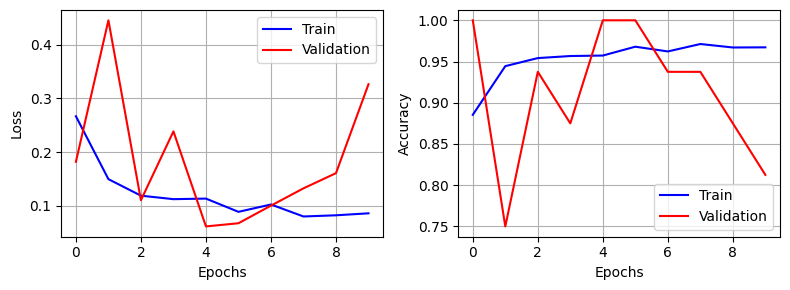

In [ ]:

plt.figure(figsize=(8, 3))
# Plot Loss Curve (Train + Validation)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.plot(history["epoch"], history["train_loss"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# prepare for storing evaluation metrics
test_acc = Accuracy(task='multiclass', num_classes=num_class).to(device)
test_confusion_matrix=ConfusionMatrix(task="multiclass", num_classes=num_class).to(device)
test_precision = Precision(task="multiclass", num_classes=num_class, average="macro").to(device)
test_recall = Recall(task="multiclass", num_classes=num_class, average="macro").to(device)
test_f1_score = F1Score(task="multiclass", num_classes=num_class, average="macro").to(device)

model = model.to(device)
model.eval() # set model to evaluation mode
with torch.no_grad():
  for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    preds = model(X) # model forward
    preds = preds.argmax(dim=1) # obtain the final predicted class
    # store loss and accuracy per batc
    test_confusion_matrix.update(preds, Y)
    test_acc.update(preds, Y)
    test_precision.update(preds, Y)
    test_recall.update(preds, Y)
    test_f1_score.update(preds, Y)
  # Print the results
  print("Confusion Matrix:\n", test_confusion_matrix.compute())
  print("Accuracy:", test_acc.compute().item())
  print("Precision:", test_precision.compute().item())
  print("Recall:", test_recall.compute().item())
  print("F1 Score:", test_f1_score.compute().item())

Confusion Matrix:
 tensor([[207,  27],
        [ 37, 353]], device='cuda:0')
Accuracy: 0.8974359035491943
Precision: 0.8886539936065674
Recall: 0.8948717713356018
F1 Score: 0.891495943069458


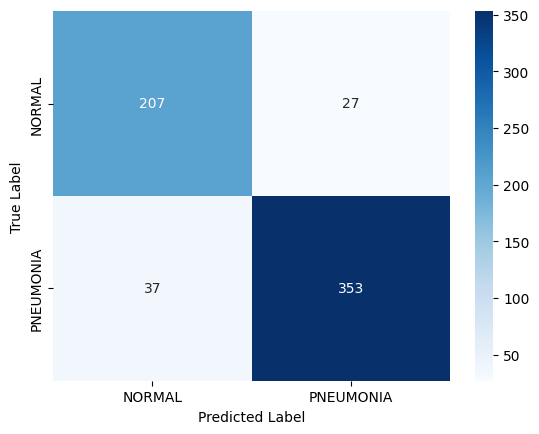

In [ ]:
# Create a heatmap for better confusion matrix visualization
sns.heatmap(test_confusion_matrix.compute().cpu(), annot=True, fmt="d",
            cmap="Blues", xticklabels=classes, yticklabels=classes)
# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input channels: 3 (RGB)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)              # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
model = CustomCNN(num_classes=2).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 12
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validation_one_epoch(model, val_loader)

    # Print stats
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")


100%|██████████| 163/163 [04:59<00:00,  1.84s/it]


Epoch 0: Train Loss = 0.5159, Train Acc = 0.7947, Val Loss = 0.7386, Val Acc = 0.7500


100%|██████████| 163/163 [04:58<00:00,  1.83s/it]


Epoch 1: Train Loss = 0.3511, Train Acc = 0.8476, Val Loss = 0.8865, Val Acc = 0.6250


100%|██████████| 163/163 [04:58<00:00,  1.83s/it]


Epoch 2: Train Loss = 0.2993, Train Acc = 0.8708, Val Loss = 0.7359, Val Acc = 0.7500


100%|██████████| 163/163 [05:00<00:00,  1.84s/it]


Epoch 3: Train Loss = 0.2719, Train Acc = 0.8909, Val Loss = 0.5215, Val Acc = 0.6875


100%|██████████| 163/163 [05:00<00:00,  1.84s/it]


Epoch 4: Train Loss = 0.2397, Train Acc = 0.9041, Val Loss = 0.4942, Val Acc = 0.8750


100%|██████████| 163/163 [05:01<00:00,  1.85s/it]


Epoch 5: Train Loss = 0.2401, Train Acc = 0.9043, Val Loss = 0.4431, Val Acc = 0.8125


100%|██████████| 163/163 [05:05<00:00,  1.87s/it]


Epoch 6: Train Loss = 0.2245, Train Acc = 0.9118, Val Loss = 0.7889, Val Acc = 0.7500


100%|██████████| 163/163 [05:01<00:00,  1.85s/it]


Epoch 7: Train Loss = 0.2280, Train Acc = 0.9099, Val Loss = 0.4010, Val Acc = 0.6875


100%|██████████| 163/163 [05:00<00:00,  1.84s/it]


Epoch 8: Train Loss = 0.2138, Train Acc = 0.9183, Val Loss = 0.4853, Val Acc = 0.8125


100%|██████████| 163/163 [05:05<00:00,  1.87s/it]


Epoch 9: Train Loss = 0.2082, Train Acc = 0.9185, Val Loss = 0.9033, Val Acc = 0.7500


100%|██████████| 163/163 [05:07<00:00,  1.89s/it]


Epoch 10: Train Loss = 0.2006, Train Acc = 0.9245, Val Loss = 0.7401, Val Acc = 0.8125


100%|██████████| 163/163 [05:02<00:00,  1.86s/it]


Epoch 11: Train Loss = 0.2043, Train Acc = 0.9202, Val Loss = 1.4317, Val Acc = 0.6250


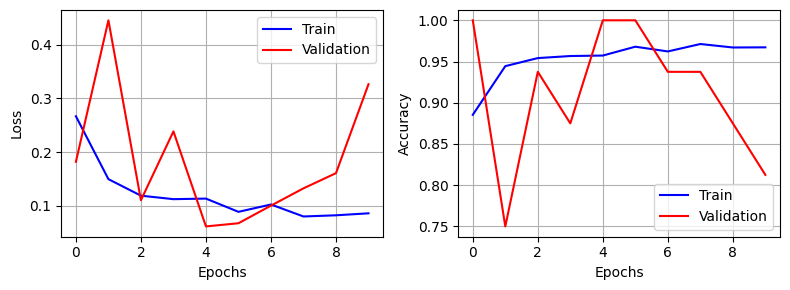

In [ ]:

plt.figure(figsize=(8, 3))
# Plot Loss Curve (Train + Validation)
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_loss"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train", color="blue")
plt.plot(history["epoch"], history["val_acc"], label="Validation", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

test_acc = Accuracy(task='multiclass', num_classes=num_class).to(device)
test_confusion_matrix=ConfusionMatrix(task="multiclass", num_classes=num_class).to(device)
test_precision = Precision(task="multiclass", num_classes=num_class, average="macro").to(device)
test_recall = Recall(task="multiclass", num_classes=num_class, average="macro").to(device)
test_f1_score = F1Score(task="multiclass", num_classes=num_class, average="macro").to(device)

model = model.to(device)
model.eval()
with torch.no_grad():
  for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    preds = model(X) # model forward
    preds = preds.argmax(dim=1)

    test_confusion_matrix.update(preds, Y)
    test_acc.update(preds, Y)
    test_precision.update(preds, Y)
    test_recall.update(preds, Y)
    test_f1_score.update(preds, Y)
  # Print the results
  print("Confusion Matrix:\n", test_confusion_matrix.compute())
  print("Accuracy:", test_acc.compute().item())
  print("Precision:", test_precision.compute().item())
  print("Recall:", test_recall.compute().item())
  print("F1 Score:", test_f1_score.compute().item())

Confusion Matrix:
 tensor([[117, 117],
        [  5, 385]], device='cuda:0')
Accuracy: 0.8044871687889099
Precision: 0.8629742860794067
Recall: 0.7435897588729858
F1 Score: 0.7602660655975342


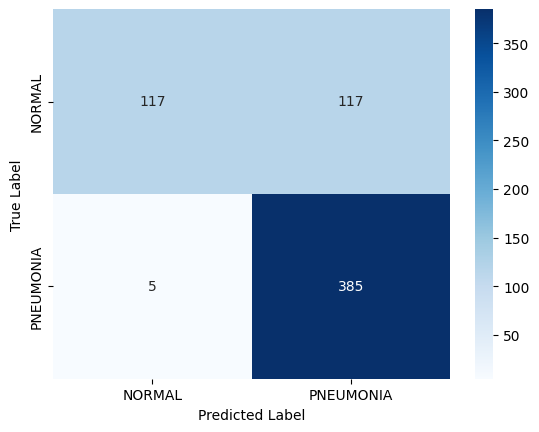

In [ ]:
# Create a heatmap for better confusion matrix visualization
sns.heatmap(test_confusion_matrix.compute().cpu(), annot=True, fmt="d",
            cmap="Blues", xticklabels=classes, yticklabels=classes)
# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()